In [2]:
import xarray as xr
import numpy as np
import rasterio as rio
import rioxarray
from affine import Affine
import geopandas as gpd
import pandas as pd
import xagg as xa
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

In [4]:
dpath = '/media/nick/Seagate Backup Plus Drive/Data/'
rpath = '/media/nick/Seagate Backup Plus Drive/Data/MCO_Drought_Plan/Exposure_Results/'

In [2]:
ds = xr.open_dataset(dpath + "Drought_Monitor/Montana_Clipped/All_Droughts_MT2.nc")
counties = gpd.read_file("zip://" + dpath + "Montana_GIS/MT_Counties.zip")

In [3]:
counties = counties[['NAME', 'COUNTYNUMB', 'geometry']]
counties.index = counties['COUNTYNUMB']
counties.drop(columns=['COUNTYNUMB'], inplace=True)

In [4]:
ds_slice = ds.sel(time=slice('2001-01-01', '2021-12-31'))
ds_djf = ds_slice['DM'].loc[ds_slice["time.month"].isin([12, 1, 2])]
ds_mam = ds_slice['DM'].loc[ds_slice["time.month"].isin([3, 4, 5])]
ds_jja = ds_slice['DM'].loc[ds_slice["time.month"].isin([6, 7, 8])]
ds_son = ds_slice['DM'].loc[ds_slice["time.month"].isin([9, 10, 11])]

In [5]:
drought = ds_slice['DM'].where(ds_slice['DM'] >= 2).sum(dim='time', skipna=True, min_count=1)
drought_djf = ds_djf.where(ds_djf >= 2).sum(dim='time', skipna=True, min_count=1)
drought_mam = ds_mam.where(ds_mam >= 2).sum(dim='time', skipna=True, min_count=1)
drought_jja = ds_jja.where(ds_jja >= 2).sum(dim='time', skipna=True, min_count=1)
drought_son = ds_son.where(ds_son >= 2).sum(dim='time', skipna=True, min_count=1)

In [6]:
slope = ds_slice.polyfit(dim='time', deg=1, skipna=True).sel(degree=1)
slope_djf = ds_djf.polyfit(dim='time', deg=1, skipna=True).sel(degree=1)
slope_mam = ds_mam.polyfit(dim='time', deg=1, skipna=True).sel(degree=1)
slope_jja = ds_jja.polyfit(dim='time', deg=1, skipna=True).sel(degree=1)
slope_son = ds_son.polyfit(dim='time', deg=1, skipna=True).sel(degree=1)

In [20]:
# Convert from nanosecond to year 
slope = slope.DM_polyfit_coefficients/3.171e-17
slope_djf = slope_djf.polyfit_coefficients/3.171e-17
slope_mam = slope_mam.polyfit_coefficients/3.171e-17
slope_jja = slope_jja.polyfit_coefficients/3.171e-17
slope_son = slope_son.polyfit_coefficients/3.171e-17


In [7]:
drought.rio.to_raster(rpath + 'D2_Drought_Freq_2001-2021.tif')
drought_djf.rio.to_raster(rpath + 'D2_Drought_Freq_DJF_2001-2021.tif')
drought_mam.rio.to_raster(rpath + 'D2_Drought_Freq_MAM_2001-2021.tif')
drought_jja.rio.to_raster(rpath + 'D2_Drought_Freq_JJA_2001-2021.tif')
drought_son.rio.to_raster(rpath + 'D2_Drought_Freq_SON_2001-2021.tif')

In [23]:
slope.rio.to_raster(rpath + '/D2_Drought_Change_2001-2021.tif')
slope_djf.rio.to_raster(rpath + '/D2_Drought_Change_DJF_2001-2021.tif')
slope_mam.rio.to_raster(rpath + '/D2_Drought_Change_MAM_2001-2021.tif')
slope_jja.rio.to_raster(rpath + '/D2_Drought_Change_JJA_2001-2021.tif')
slope_son.rio.to_raster(rpath + '/D2_Drought_Change_SON_2001-2021.tif')

I could not figure out how to get rasterstats or xagg to work with these data so I ended up exporting and doing the zonal statistics in qgis. 

In [79]:
# Bring in drought frequency statistics
d = gpd.read_file(rpath + 'County_Stats_D2_Drought_Freq_2001-2021.shp')
d_djf = gpd.read_file(rpath + 'County_Stats_D2_Drought_Freq_DJF_2001-2021.shp')
d_mam = gpd.read_file(rpath + 'County_Stats_D2_Drought_Freq_MAM_2001-2021.shp')
d_jja = gpd.read_file(rpath + 'County_Stats_D2_Drought_Freq_JJA_2001-2021.shp')
d_son = gpd.read_file(rpath + 'County_Stats_D2_Drought_Freq_SON_2001-2021.shp')

# Bring in drought change statistics
s = gpd.read_file(rpath + 'County_Stats_D2_Drought_Change_2001-2021.shp')
s_djf = gpd.read_file(rpath + 'County_Stats_D2_Drought_Change_DJF_2001-2021.shp')
s_mam = gpd.read_file(rpath + 'County_Stats_D2_Drought_Change_MAM_2001-2021.shp')
s_jja = gpd.read_file(rpath + 'County_Stats_D2_Drought_Change_JJA_2001-2021.shp')
s_son = gpd.read_file(rpath + 'County_Stats_D2_Drought_Change_SON_2001-2021.shp')

In [29]:
# Combine into one dataframe
d_list = [d, d_djf, d_mam, d_jja, d_son]
d_names = ['All_Seasons', 'DJF', 'MAM', 'JJA', 'SON']
cols = ['NAME', 'D_mean', 'geometry']
df_all = pd.DataFrame()
for i, df in enumerate(d_list):
    df = df[cols]
    df = df.rename({'D_mean': d_names[i]}, axis=1)
    if i == 0:
        df_all = df
    else:
        df_all = df_all.merge(df[['NAME', d_names[i]]], on='NAME')
        
s_list = [s, s_djf, s_mam, s_jja, s_son]
d_names = ['All_Seasons_Change', 'DJF_Change', 'MAM_Change', 'JJA_Change', 'SON_Change']
cols = ['NAME', 'D_mean', 'geometry']
for i, df in enumerate(s_list):
    df = df[cols]
    df = df.rename({'D_mean': d_names[i]}, axis=1)
    df_all = df_all.merge(df[['NAME', d_names[i]]], on='NAME')

new_cols = [col for col in df_all.columns if col != 'geometry'] + ['geometry']
df_all = df_all[new_cols]

In [30]:
df_all.head()

,NAME,All_Seasons,DJF,MAM,JJA,SON,All_Seasons_Change,DJF_Change,MAM_Change,JJA_Change,SON_Change,geometry
0,CARBON,606.645646,137.279279,151.720721,126.630631,191.015015,-0.057763,-0.067702,-0.099936,-0.036468,-0.045528,"POLYGON ((655960.572 154586.099, 655964.106 15..."
1,POWDER RIVER,498.926276,149.519849,94.086957,96.455577,158.863894,-0.022458,-0.037788,-0.072822,-0.004760,0.000889,"POLYGON ((951050.748 179940.900, 951073.768 17..."
2,MADISON,569.126712,105.029110,120.061644,158.407534,185.628425,-0.047272,-0.068165,-0.116142,-0.008708,-0.021361,"POLYGON ((404410.103 181901.224, 404440.783 18..."
3,BEAVERHEAD,497.974501,89.471175,106.621951,138.515521,163.365854,-0.048820,-0.062222,-0.115115,-0.023177,-0.023346,"POLYGON ((290036.330 195769.471, 290102.640 19..."
4,BIG HORN,529.330882,145.187500,116.696078,107.930147,159.517157,-0.058118,-0.051753,-0.122193,-0.042626,-0.050189,"POLYGON ((760743.309 192187.542, 760752.953 19..."


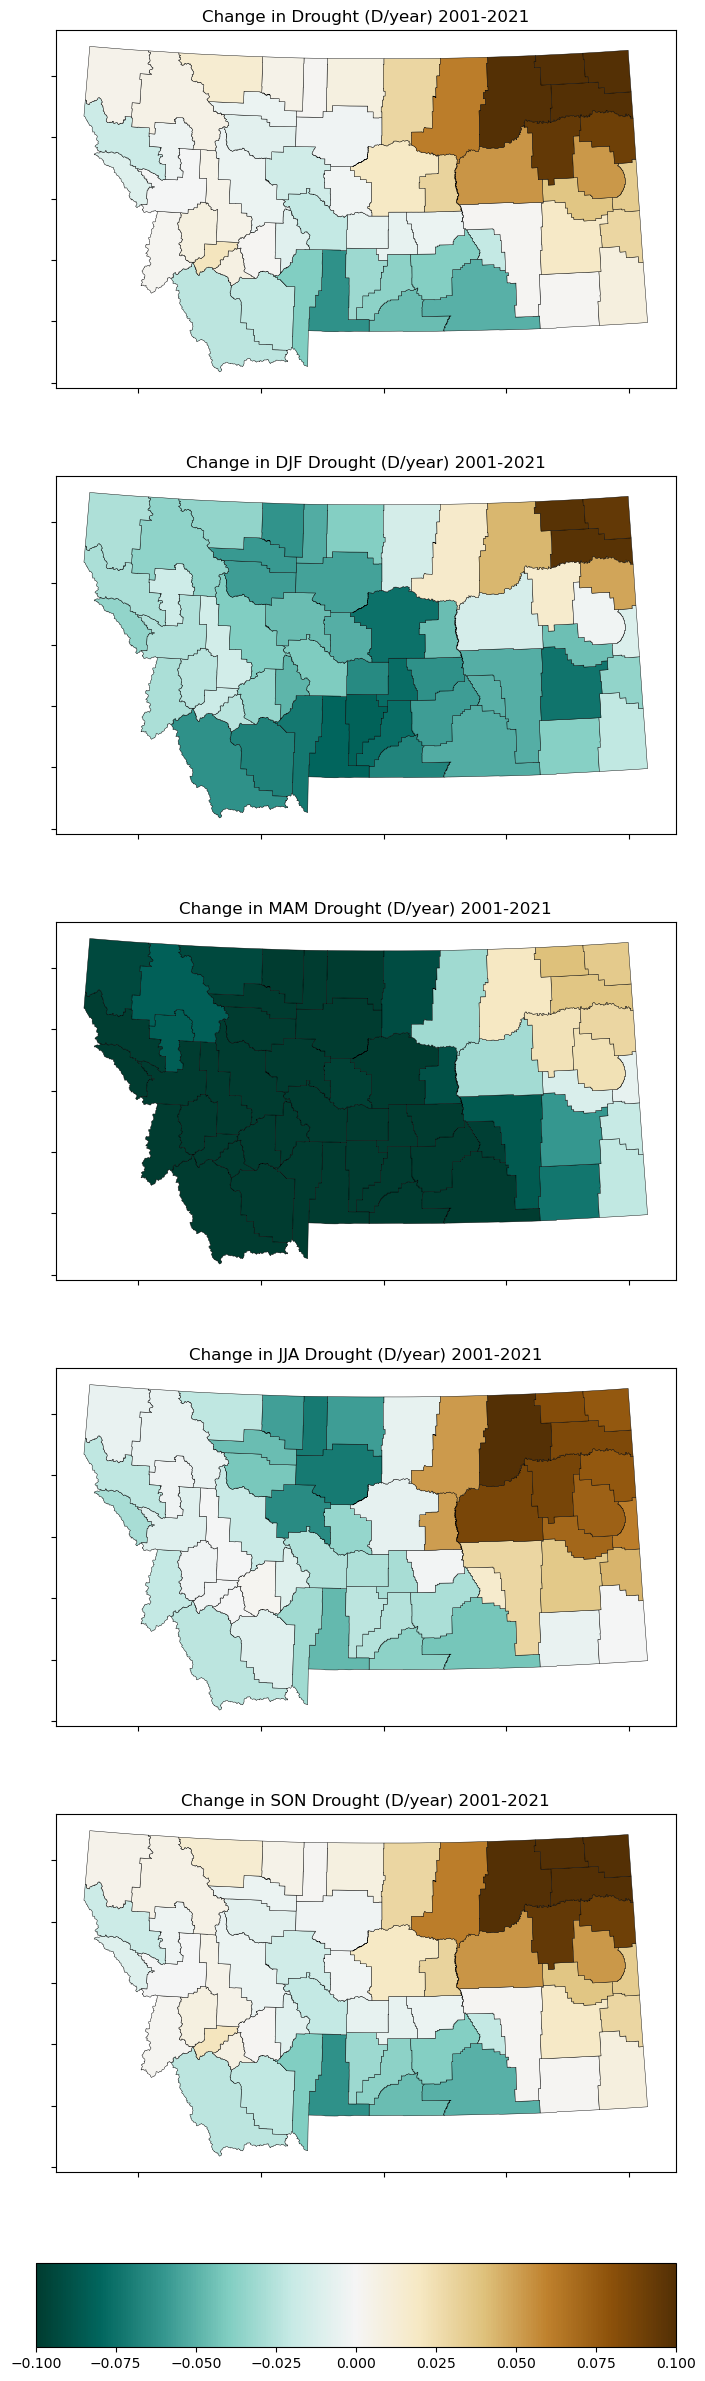

In [73]:
import matplotlib.pyplot as plt
s_list = [s, s_djf, s_mam, s_jja, s_son]
s_titles = [
    'Change in Drought (D/year) 2001-2021',
    'Change in DJF Drought (D/year) 2001-2021',
    'Change in MAM Drought (D/year) 2001-2021',
    'Change in JJA Drought (D/year) 2001-2021',
    'Change in SON Drought (D/year) 2001-2021',
    ]

fig, axs = plt.subplots(5, 1, figsize=(8, 28))
for i, s in enumerate(s_list):
    p = s.plot(column='D_mean', ax=axs[i], vmin=-0.1, vmax=0.1, cmap='BrBG_r', edgecolor='black', linewidth=0.3)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_title(s_titles[i])
    im = plt.gca().get_children()[0]
cax = fig.add_axes([0.1,0.05,0.8,0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', ax=axs.ravel().tolist())


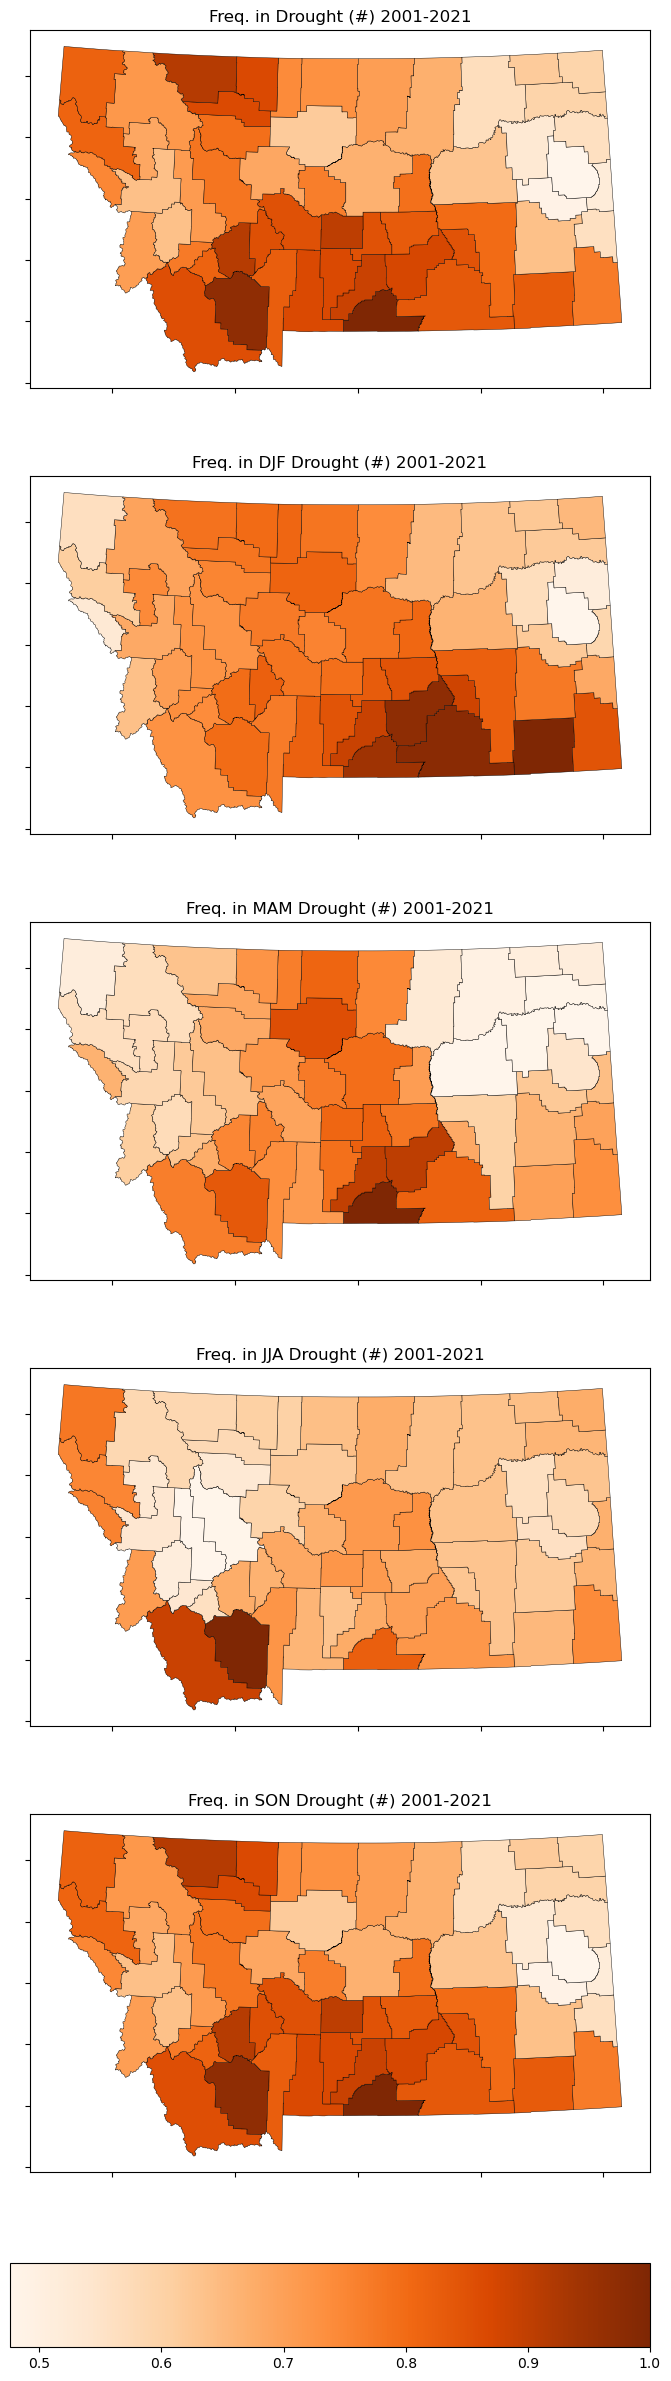

In [87]:
import matplotlib.pyplot as plt
d_list = [d, d_djf, d_mam, d_jja, d_son]
s_titles = [
    'Freq. in Drought (#) 2001-2021',
    'Freq. in DJF Drought (#) 2001-2021',
    'Freq. in MAM Drought (#) 2001-2021',
    'Freq. in JJA Drought (#) 2001-2021',
    'Freq. in SON Drought (#) 2001-2021',
    ]

fig, axs = plt.subplots(5, 1, figsize=(8, 28))
for i, d in enumerate(d_list):
    maxval = d['D_mean'].max()
    d['D_mean_norm'] = d['D_mean']/maxval
    p = d.plot(column='D_mean_norm', ax=axs[i], cmap='Oranges', edgecolor='black', linewidth=0.3)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_title(s_titles[i])
    im = plt.gca().get_children()[0]
cax = fig.add_axes([0.1,0.05,0.8,0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', ax=axs.ravel().tolist())
